In [44]:
%pylab inline

import pandas as pd
import pickle
from scipy.linalg import norm
import cv2 as cv
import os
import importlib
from sklearn.preprocessing import normalize
from skimage.io import imsave, imread
import os
import glob
import argparse
import time
import pickle
import platform
import shutil

import numpy as np
import pandas as pd
import cv2 as cv
from skimage.io import imsave
from scipy.stats import entropy
from scipy.linalg import norm
import h5py

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda, ZeroPadding2D, LeakyReLU, Flatten, Concatenate
from keras.layers.merge import add
from keras.utils import multi_gpu_model
from keras.utils.data_utils import Sequence
import keras.backend as K
from keras import optimizers


Populating the interactive namespace from numpy and matplotlib


D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['add', 'norm', 'entropy', 'imread', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
cd D:\\topcoder\\face_recog\\src\\space

D:\topcoder\face_recog\src\space


In [8]:
import sys
sys.path.append('D:\\topcoder\\face_recog\\src')

In [9]:
with open('db_facial_id.pobj', 'rb') as f:
    facial_ids = pickle.load(f)

In [10]:
diff_norms = []
for subject_id in facial_ids:
    diff_norms.append(norm(facial_ids[1] - facial_ids[subject_id]))
diff_norms = np.asarray(diff_norms)[1:]

In [11]:
diff_norms.min(), diff_norms.max(), diff_norms.mean()

(0.22102928161621094, 1.1220169067382812, 0.6192618016981416)

(array([ 1.,  3.,  1.,  2.,  8.,  4.,  9.,  7., 14., 17., 12., 15., 11.,
        12.,  9.,  9., 15.,  3., 21.,  8.,  9., 14., 17., 19., 20.,  9.,
         8., 19., 10., 18., 19.,  7., 16.,  9., 15., 19., 15., 26., 20.,
        20., 19., 23., 11., 22., 11., 18., 20., 11., 11., 13., 21., 12.,
        10., 18., 15., 16., 22.,  8.,  7., 15.,  9., 16., 11., 13., 14.,
        19., 12.,  9.,  8., 17., 10.,  9.,  9.,  4.,  9., 12., 11., 11.,
         4.,  8.,  7.,  4.,  7.,  7.,  7.,  5.,  3.,  1.,  3.,  8.,  1.,
         3.,  2.,  5.,  3.,  2.,  2.,  0.,  1.,  1.]),
 array([0.22102928, 0.23003916, 0.23904903, 0.24805891, 0.25706879,
        0.26607866, 0.27508854, 0.28409842, 0.29310829, 0.30211817,
        0.31112804, 0.32013792, 0.3291478 , 0.33815767, 0.34716755,
        0.35617743, 0.3651873 , 0.37419718, 0.38320705, 0.39221693,
        0.40122681, 0.41023668, 0.41924656, 0.42825644, 0.43726631,
        0.44627619, 0.45528606, 0.46429594, 0.47330582, 0.48231569,
        0.49132557, 0.5003

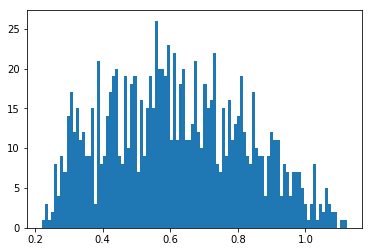

In [12]:
hist(diff_norms, bins=100)

0.0 1.1574599742889404 0.7958166379547031


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  2.,  0.,  0.,
         0.,  2.,  3.,  2.,  3.,  5.,  3.,  6.,  7.,  5.,  5.,  4., 10.,
         5.,  9., 15., 15., 26., 25., 25., 27., 24., 35., 37., 40., 37.,
        38., 46., 27., 52., 37., 47., 45., 45., 39., 45., 35., 29., 29.,
        19., 20., 19., 15., 15., 14.,  8., 12.,  5., 13., 13.,  6.,  6.,
         5.,  7.,  1.,  3.,  2.,  1.,  1.,  0.,  1.]),
 array([0.        , 0.0115746 , 0.0231492 , 0.0347238 , 0.0462984 ,
        0.057873  , 0.0694476 , 0.0810222 , 0.0925968 , 0.1041714 ,
        0.115746  , 0.1273206 , 0.1388952 , 0.1504698 , 0.1620444 ,
        0.173619  , 0.1851936 , 0.1967682 , 0.2083428 , 0.2199174 ,
        0.23149199, 0.24306659, 0.25464119, 0.26621579, 0.27779039,
        0.28936499, 0.30093959, 0.31251419, 0.32408879, 0.33566339,
        0.34723799, 0.3588

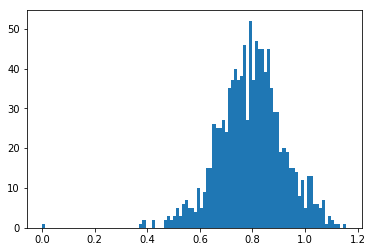

In [13]:
diff_norms = []
for subject_id in facial_ids:
    diff_norms.append(norm(facial_ids[2] - facial_ids[subject_id]))
diff_norms = np.asarray(diff_norms)
print(diff_norms.min(), diff_norms.max(), diff_norms.mean())
hist(diff_norms, bins=100)

0.0 1.2462674379348755 0.868333381182832


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  2.,
         2.,  3.,  2.,  2.,  3.,  3.,  4.,  4.,  8.,  5.,  5.,  4.,  3.,
         5.,  2.,  3.,  4.,  6.,  4.,  7., 10.,  5., 16., 11.,  9.,  7.,
         7., 13.,  8., 10., 15., 17., 17., 16., 11., 18., 18., 13., 21.,
        13., 19., 29., 20., 22., 33., 32., 27., 31., 33., 44., 35., 45.,
        36., 47., 41., 47., 36., 43., 25., 29., 26.,  9.,  8.,  4.,  2.,
         2.,  4.,  3.,  2.,  1.,  1.,  0.,  1.,  3.]),
 array([0.        , 0.01246267, 0.02492535, 0.03738802, 0.0498507 ,
        0.06231337, 0.07477605, 0.08723872, 0.0997014 , 0.11216407,
        0.12462674, 0.13708942, 0.14955209, 0.16201477, 0.17447744,
        0.18694012, 0.19940279, 0.21186546, 0.22432814, 0.23679081,
        0.24925349, 0.26171616, 0.27417884, 0.28664151, 0.29910419,
        0.31156686, 0.32402953, 0.33649221, 0.34895488, 0.36141756,
        0.37388023, 0.3863

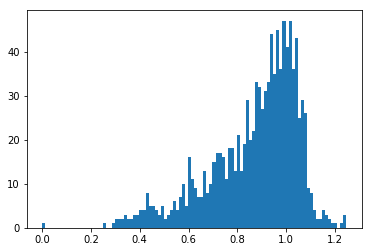

In [14]:
diff_norms = []
for subject_id in facial_ids:
    diff_norms.append(norm(facial_ids[3] - facial_ids[subject_id]))
diff_norms = np.asarray(diff_norms)
print(diff_norms.min(), diff_norms.max(), diff_norms.mean())
hist(diff_norms, bins=100)

1
0.0 1.1220169067382812 0.618688941567061


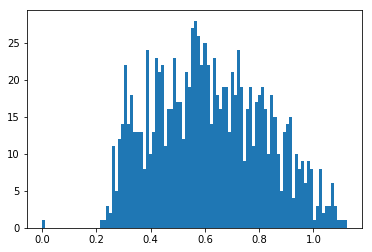

In [15]:
for subject_id_t in list(facial_ids.keys())[:1]:
    print(subject_id_t)
    diff_norms = []
    for subject_id_b in facial_ids:
        diff_norms.append(norm(facial_ids[subject_id_t] - facial_ids[subject_id_b]))
    diff_norms = np.asarray(diff_norms)
    print(diff_norms.min(), diff_norms.max(), diff_norms.mean())
    hist(diff_norms, bins=100)

In [16]:
ref_facial_ids = facial_ids

In [17]:
hps = {}
hps['step'] = 1
raw_data_path = 'D:\\topcoder\\face_recog\\resource\\training'
output_file_path = 'D:\\topcoder\\face_recog\\resource\\solution_training.csv'
hps['image_size'] = 416
hps['num_dense1_layers'] = 1
hps['dense1'] = 64
hps['num_dense2_layers'] = 1
hps['dense2'] = 64
hps['lr'] = 0.0001
hps['beta_1'] = 0.99
hps['beta_2'] = 0.99
hps['decay'] = 0.0
hps['batch_size'] = 5
hps['epochs'] = 2
hps['face_conf_th'] = 0.5
hps['nms_iou_th'] = 0.5
hps['num_cands'] = 60
hps['sim_th'] = 0.1
model_loading = True

In [18]:
import face_identification

In [19]:
importlib.reload(face_identification)

<module 'face_identification' from 'D:\\topcoder\\face_recog\\src\\space\\face_identification.py'>

In [20]:
fr = face_identification.FaceIdentifier(raw_data_path, hps, model_loading)

In [21]:
db = pd.read_csv('db.csv')
db = db.iloc[:, 1:]
db_g = db.groupby('subject_id')

In [22]:
subject_ids = db_g.groups.keys()

In [23]:
subject_ids

dict_keys([1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 59, 60, 62, 64, 65, 67, 68, 69, 70, 72, 73, 74, 75, 77, 79, 80, 82, 83, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 114, 115, 116, 117, 119, 120, 122, 123, 124, 125, 126, 127, 129, 130, 131, 133, 134, 136, 137, 138, 139, 140, 144, 146, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 170, 172, 175, 178, 179, 181, 182, 183, 184, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 211, 213, 214, 216, 218, 219, 220, 224, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 239, 241, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259, 260, 261, 262, 264, 266, 267, 268, 269, 271, 272, 273, 274, 276, 277, 278, 279, 280, 281, 282,

In [25]:
db

,subject_id,face_file,w,h
0,1,3021f5723e5af668c77ef2e41423dcf8_1_2948_1923.jpg,378,453
1,1,b0cc228dbe4ac1854b3f3a697e92296f_1_4729_2290.jpg,307,428
2,2,01819edd97f84cf2c50f416af260f024_2_545_2080.jpg,350,420
3,2,0e455dac98b2983d35e42c8ee22d8fd9_2_1035_2343.jpg,310,392
4,2,0f4c89efef478bd2ab00f9538b3fbd35_2_382_2017.jpg,331,398
5,2,171629db8796252437c3e8f7d88790cf_2_88_1996.jpg,335,402
6,2,50aa0096bd1faf54fe523498a1994c24_2_1104_3016.jpg,355,407
7,2,62905eff888b35e9f8e0cb091f5240ef_2_1310_2350.jpg,316,366
8,2,7181a932f3dc4ef412d3595d690649e4_2_844_2164.jpg,333,400
9,2,958d8cf433d6f4d573563600c9d2eb8e_2_1382_2439.jpg,351,408


In [69]:
facial_ids_dict= {}

In [70]:
subject_id = 1
df = db_g.get_group(subject_id)
images = []
for ff in list(df.iloc[:, 1]):
    image = imread(os.path.join('subject_faces', ff))
    images.append(image/255)
images = np.asarray(images)
facial_ids = fr.fid_extractor.predict(images)
facial_ids_dict[subject_id] = facial_ids
facial_ids.shape

(2, 64)

In [71]:
images[0].mean(), images[0].max()

(0.33885938466856186, 0.792156862745098)

In [72]:
norm(facial_ids[1] - facial_ids[0]) 

0.6564363837242126

In [73]:
norm(facial_ids[1])

0.9999999403953552

In [74]:
norm(facial_ids[0] - ref_facial_ids[1])

0.3282181918621063

In [75]:
for i in range(facial_ids.shape[1]):
    print(facial_ids[0,i], facial_ids[1,i], ref_facial_ids[1][i])

0.04090014 0.0 0.02045007
0.03977998 0.0 0.01988999
0.19046932 0.0 0.09523466
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.09083261 0.045416307
0.0 0.0 0.0
0.10685497 0.0 0.053427484
0.0 0.0 0.0
0.09216177 0.09694002 0.09455089
0.06337923 0.0 0.031689614
0.16797353 0.07752244 0.12274799
0.0 0.0 0.0
0.0 0.064892024 0.032446012
0.0 0.15904397 0.079521984
0.0 0.0 0.0
0.33197746 0.30113384 0.31655565
0.0 0.057104085 0.028552042
0.34729454 0.3217736 0.33453405
0.0 0.22355926 0.11177963
0.0 0.0 0.0
0.0 0.014336667 0.0071683335
0.079082675 0.0 0.039541338
0.0 0.0 0.0
0.0 0.0 0.0
0.12397027 0.0 0.061985135
0.0 0.03314824 0.01657412
0.0 0.0 0.0
0.18859637 0.23819974 0.21339805
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.10889461 0.054447304
0.27906024 0.16343652 0.22124839
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.17898594 0.08949297
0.0 0.13046496 0.06523248
0.0 0.0 0.0
0.014301421 0.0 0.0071507106
0.22975554 0.24071017 0.23523286
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0063292254 0.0031646127
0.27587554 0.2

In [76]:
subject_id = 2
df = db_g.get_group(subject_id)
images = []
for ff in list(df.iloc[:, 1]):
    image = cv.imread(os.path.join('subject_faces', ff))
    r = image[:, :, 0].copy()
    g = image[:, :, 1].copy()
    b = image[:, :, 2].copy()
    image[:, :, 0] = b
    image[:, :, 1] = g
    image[:, :, 2] = r 
    images.append(image/255)
images = np.asarray(images)
facial_ids = fr.fid_extractor.predict(images)
facial_ids_dict[subject_id] = facial_ids
facial_ids.shape

(13, 64)

In [77]:
for i in range(facial_ids.shape[0]): print(norm(facial_ids[i]))

0.9999999403953552
1.0000001192092896
1.0
0.9999999403953552
1.0
1.0
0.9999999403953552
0.9999999403953552
1.0
1.0
0.9999999403953552
1.0
1.0


In [78]:
norm(facial_ids[0] - facial_ids[1]) 

0.135909765958786

In [79]:
dists = []
for i in range(facial_ids.shape[0] - 1):
    for j in range(i + 1, facial_ids.shape[0]):
        dists.append(norm(facial_ids[i] - facial_ids[j]))
dists = np.asarray(dists)
print(dists.min(), dists.max(), dists.mean())

0.0781058669090271 0.6144140362739563 0.29359102497498196


In [80]:
norm(facial_ids_dict[1][0] - facial_ids[1][1])

1.3032399415969849

In [81]:
res = fr.fid_extractor.predict(np.random.rand(1, 416, 416, 3))

In [82]:
norm(res)

1.0

In [83]:
subject_id = 3
df = db_g.get_group(subject_id)
images = []
for ff in list(df.iloc[:, 1]):
    image = imread(os.path.join('subject_faces', ff))
    images.append(image/255)
images = np.asarray(images)

In [84]:
images.shape

(28, 416, 416, 3)

In [85]:
images[0].shape

(416, 416, 3)

In [86]:
facial_ids = fr.fid_extractor.predict(images)

In [87]:
facial_ids.shape

(28, 64)

In [88]:
res = facial_ids[0]
res.shape

(64,)

In [89]:
norm(res)

1.0

In [90]:
norm(facial_ids[0])

1.0

In [91]:
res = fr.fid_extractor.predict(images[0:2])

In [92]:
res.shape

(2, 64)

In [93]:
res[0].shape

(64,)

In [94]:
norm(res[1])

0.9999999403953552

In [95]:
dists = []
for i in range(facial_ids.shape[0] - 1):
    for j in range(i + 1, facial_ids.shape[0]):
        dists.append(norm(facial_ids[i] - facial_ids[j]))
dists = np.asarray(dists)
print(dists.min(), dists.max(), dists.mean())

0.119878850877285 0.8533779978752136 0.3935427498368044


In [96]:
image = imread(os.path.join('subject_faces', ff))

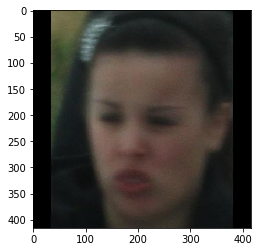

In [97]:
imshow(image)

In [12]:
from skimage.io import imread, imsave
from skimage.transform import resize 
from skimage.draw import polygon_perimeter, set_color

from PIL import Image, ImageFont, ImageDraw

In [16]:
imageObject = Image.fromarray(image, mode='RGB')
imageDraw = ImageDraw.Draw(imageObject)

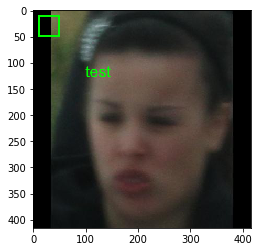

In [17]:
font = ImageFont.truetype('arial.ttf', 30)
imageDraw.text((100, 100), 'test', fill=(0,255,0), font=font)
imageDraw.rectangle([10, 10, 50, 50], outline=(0,255,0), width=3)
imshow(np.asarray(imageObject))

In [45]:
res = fr.fid_extractor.predict(image[np.newaxis, ...]/255)

In [46]:
res.shape

(1, 64)

In [47]:
norm(res)

0.9999999

In [48]:
b, g, t = cv.split(image)

In [49]:
m_image = cv.merge((b, np.zeros(shape=(416,416), dtype=uint8), np.zeros(shape=(416,416), dtype=uint8)))

In [50]:
ff

'fd5723edbcc50150c7cdbd06fe2f9111_3_2399_2776.jpg'

In [51]:
image2 = imread(os.path.join('subject_faces', ff))

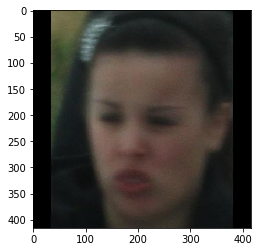

In [52]:
imshow(image2)

In [80]:
image2.shape

(416, 416, 3)

In [46]:
for subject_id in list(subject_ids)[:100]:
    df = db_g.get_group(subject_id)
    images = []
    for ff in list(df.iloc[:, 1]):
        image = imread(os.path.join('subject_faces', ff))
        images.append(image/255)
    images = np.asarray(images)
    facial_ids = fr.fid_extractor.predict(images)
    
    dists = []
    for i in range(facial_ids.shape[0] - 1):
        for j in range(i + 1, facial_ids.shape[0]):
            dists.append(norm(facial_ids[i] - facial_ids[j]))
    dists = np.asarray(dists)
    
    ref_dists = []
    for i in range(facial_ids.shape[0]):
        ref_dists.append(norm(ref_facial_ids[subject_id] - facial_ids[i]))
    ref_dists = np.asarray(ref_dists)
    
    #if len(dists) != 0: print(subject_id, dists.min(), dists.max(), dists.mean())
    if len(dists) != 0: print(subject_id, ref_dists.min(), ref_dists.max(), ref_dists.mean()) 

1 0.3282181918621063 0.3282181918621063 0.3282181918621063
2 0.09776227176189423 0.4496275782585144 0.19587569454541573
3 0.14648465812206268 0.6909347772598267 0.27209533963884625
5 0.22532857954502106 0.6506620645523071 0.3906365147658757
6 0.1292135864496231 0.46190983057022095 0.24524033218622207
7 0.1636487990617752 0.4223509132862091 0.2570698857307434
8 0.11237556487321854 0.3275497257709503 0.22105075005027983
9 0.1800781637430191 0.4633833169937134 0.2848810525167556
10 0.27548903226852417 0.27548903226852417 0.27548903226852417
11 0.4075438976287842 0.5887928605079651 0.4979041814804077
12 0.12606452405452728 0.6607770323753357 0.25329342221512513
13 0.3103359639644623 0.31033599376678467 0.3103359788656235
16 0.10277058184146881 0.5460433959960938 0.21784452108606214
17 0.34336137771606445 0.4759681522846222 0.39208707213401794
18 0.3369521200656891 0.41645216941833496 0.37697476893663406
20 0.4359006881713867 0.4359006881713867 0.4359006881713867
21 0.3247784376144409 0.491

In [47]:
for subject_id in list(subject_ids)[:100]:
    df = db_g.get_group(subject_id)
    images = []
    for ff in list(df.iloc[:, 1]):
        image = imread(os.path.join('subject_faces', ff))
        images.append(image/255)
    images = np.asarray(images)
    facial_ids = fr.fid_extractor.predict(images)
    
    dists = []
        
    for i in range(facial_ids.shape[0]):
        for subject_id_p in list(subject_ids)[:100]:
            if subject_id_p == subject_id: continue
            dists.append(norm(facial_ids[i] - ref_facial_ids[subject_id_p]))
                
    dists = np.asarray(dists)
        
    if len(dists) != 0: print(subject_id, dists.min(), dists.max(), dists.mean())

1 0.30392056703567505 1.2681528329849243 0.622514363491174
2 0.5279995203018188 1.1687475442886353 0.8758791570248489
3 0.2531627416610718 1.2098956108093262 0.8236650763587519
5 0.23516255617141724 1.2391843795776367 0.6389886435750243
6 0.2377052903175354 1.2061262130737305 0.6133693524081297
7 0.2037312239408493 1.2438901662826538 0.6614966954095195
8 0.2082042247056961 1.2929039001464844 0.6628061068044635
9 0.19181610643863678 1.2440906763076782 0.6434196394013922
10 0.3424980342388153 1.2475141286849976 0.6403603859321035
11 0.20997650921344757 1.2108741998672485 0.7054000479554889
12 0.2144407033920288 1.216333031654358 0.6214638077036936
13 0.2653812766075134 1.1587035655975342 0.6531599480094332
16 0.17491118609905243 1.253640055656433 0.5894149730777694
17 0.33631473779678345 1.189286470413208 0.7542514649505165
18 0.21779915690422058 1.2106177806854248 0.6757441926183123
20 0.31721100211143494 1.2196459770202637 0.7084443414151066
21 0.30964940786361694 1.3016996383666992 0.

In [83]:
from keras import backend as K
from keras.layers import Layer, Input, Flatten, Dense
from keras.models import Model

class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.rbm_weight = self.add_weight(name='rbm_weight'
                                 , shape=(input_shape[1], self.output_dim)
                                 , initializer='uniform' # Which initializer is optimal?
                                 , trainable=True)

        self.hidden_bias = self.add_weight(name='rbm_hidden_bias'
                                           , shape=(self.output_dim, )
                                           , initializer='uniform'
                                           , trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.sigmoid(K.dot(x, self.rbm_weight) + self.hidden_bias) # Float type?

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def fit(self, x):
        pass

In [85]:
input1 = Input(shape=(100,))
x = MyLayer(10)(input1)
x = Dense(10, activation='softmax')(x)
model = Model(input1, x)
model.compile(optimizer='sgd', loss='categorical_crossentropy')
model.fit(np.random.rand(1,100), np.random.rand(1,10))

Epoch 1/1
1/1 [==============================] - 8s 8s/step - loss: 11.2390


In [3]:
import numpy as np

from keras import backend as K
from keras.layers import Layer, Input
from tensorflow.keras import initializers

class RBM(Layer):
    """Restricted Boltzmann Machine based on Keras."""
    def __init__(self, hps, output_dim, name=None, **kwargs):
        self.hps = hps
        self.output_dim = output_dim
        self.name = name
        super(RBM, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.rbm_weight = self.add_weight(name='rbm_weight'
                                 , shape=(input_shape[1], self.output_dim)
                                 , initializer='uniform' # Which initializer is optimal?
                                 , trainable=True)

        self.hidden_bias = self.add_weight(name='rbm_hidden_bias'
                                           , shape=(self.output_dim, )
                                           , initializer='uniform'
                                           , trainable=True)
        self.visible_bias = K.variable(initializers.get('uniform')((input_shape[1], ))
                            , dtype=K.floatx()
                            , name='rbm_visible_bias')
        
        # Make symbolic computation objects.
        # Transform visible units.
        self.input_visible = K.placeholder(shape=(None, input_shape[1]), name='input_visible')
        self.transform = K.sigmoid(K.dot(self.input_visible, self.rbm_weight) + self.hidden_bias)
        self.transform_func = K.function([self.input_visible], [self.transform])
  
        # Transform hidden units.      
        self.input_hidden = K.placeholder(shape=(None, self.output_dim), name='input_hidden')
        self.inv_transform = K.sigmoid(K.dot(self.input_hidden, K.transpose(self.rbm_weight)) + self.visible_bias)
        self.inv_transform_func = K.function([self.input_hidden], [self.inv_transform])
        
        super(RBM, self).build(input_shape)
        
    def call(self, x):
        return K.sigmoid(K.dot(x, self.rbm_weight) + self.hidden_bias) # Float type?
    
    def transform(self, v):
        return self.transform_func(v)
    
    def inv_transform(self, h):
        return self.inv_transform_func(h)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def fit(self, V, verbose=1):
        """Train RBM with the data V.
        
        Parameters
        ----------
        V : 2d numpy array
            Visible data (batch size x input_dim).
        verbose : integer
            Verbose mode (default, 1).
        """
        num_step = V.shape[0] // self.hps['batch_size'] \
            if V.shape[0] % self.hps['batch_size'] == 0 else V.shape[0] // self.hps['batch_size'] + 1 # Exception processing?
        
        # Contrastive divergence.
        v_pos = self.input_visible
        h_pos = self.transform
        v_neg = K.cast(K.less(K.random_uniform(shape=(self.hps['batch_size'], V.shape[1]))
                       , K.sigmoid(K.dot(h_pos, K.transpose(self.rbm_weight)) + self.visible_bias))
                       , dtype=np.float32)
        h_neg = K.sigmoid(K.dot(v_neg, self.rbm_weight) + self.hidden_bias)
        update = K.transpose(K.transpose(K.dot(K.transpose(v_pos), h_pos)) \
                             - K.dot(K.transpose(h_neg), v_neg))
        self.rbm_weight_update_func = K.function([self.input_visible], 
                                [K.update_add(self.rbm_weight, self.hps['lr'] * update)])
        self.hidden_bias_update_func = K.function([self.input_visible], 
                                [K.update_add(self.hidden_bias, self.hps['lr'] \
                                * (K.sum(h_pos, axis=0) - K.sum(h_neg, axis=0)))])
        self.visible_bias_update_func = K.function([self.input_visible], 
                                [K.update_add(self.visible_bias, self.hps['lr'] \
                                * (K.sum(v_pos, axis=0) - K.sum(v_neg, axis=0)))])
        
        for k in range(self.hps['epochs']):
            if verbose == 1:
                print(k, '/', self.hps['epochs'], ' epochs')
                
            for i in range(num_step):
                if i == (num_step - 1):
                    # Contrastive divergence.
                    v_pos = self.input_visible
                    h_pos = self.transform
                    v_neg = K.cast(K.less(K.random_uniform(shape=(V.shape[0] \
                                   - int(i*self.hps['batch_size']), V.shape[1])) #?
                                   , K.sigmoid(K.dot(h_pos, K.transpose(self.rbm_weight)) \
                                   + self.visible_bias)), dtype=np.float32)
                    h_neg = K.sigmoid(K.dot(v_neg, self.rbm_weight) + self.hidden_bias)
                    update = K.transpose(K.transpose(K.dot(K.transpose(v_pos), h_pos)) \
                                         - K.dot(K.transpose(h_neg), v_neg))
                    self.rbm_weight_update_func = K.function([self.input_visible], 
                            [K.update_add(self.rbm_weight, self.hps['lr'] * update)])
                    self.hidden_bias_update_func = K.function([self.input_visible], 
                            [K.update_add(self.hidden_bias, self.hps['lr'] \
                            * (K.sum(h_pos, axis=0) - K.sum(h_neg, axis=0)))])
                    self.visible_bias_update_func = K.function([self.input_visible], 
                            [K.update_add(self.visible_bias, self.hps['lr'] \
                            * (K.sum(v_pos, axis=0) - K.sum(v_neg, axis=0)))])

                    V_batch = [V[int(i*self.hps['batch_size']):V.shape[0]]]
                    
                    # Train.
                    self.rbm_weight_update_func(V_batch)
                    self.hidden_bias_update_func(V_batch)
                    self.visible_bias_update_func(V_batch)
                else:
                    V_batch = [V[int(i*self.hps['batch_size']):int((i+1)*self.hps['batch_size'])]]
                    
                    # Train.
                    self.rbm_weight_update_func(V_batch)
                    self.hidden_bias_update_func(V_batch)
                    self.visible_bias_update_func(V_batch)  

Using TensorFlow backend.


In [4]:
hps = {}
hps['lr'] = 0.1
hps['batch_size'] = 1
hps['epochs'] = 10
hps['beta_1'] = 0.99
hps['beta_2'] = 0.99
hps['decay'] = 0.0

rbm_layer = RBM(hps, 10)
input1 = Input(shape=(10, 10, 3))
x = Flatten()(input1)
x = rbm_layer(x)
output = Dense(10, activation='softmax')(x)
model = Model(inputs=[input1], outputs=[output])
opt = optimizers.Adam(lr=hps['lr']
                                , beta_1=hps['beta_1']
                                , beta_2=hps['beta_2']
                                , decay=hps['decay'])

model.compile(optimizer=opt, loss='mse')

NameError: name 'Flatten' is not defined

In [47]:
model.predict(np.random.rand(1,10,10,3))

array([[0.05225093, 0.08817174, 0.16123906, 0.06477234, 0.12430384,
        0.06368855, 0.09730622, 0.1456283 , 0.0880848 , 0.11455426]],
      dtype=float32)

In [48]:
rbm_layer.fit(np.random.rand(1, 300))

0 / 10  epochs
1 / 10  epochs
2 / 10  epochs
3 / 10  epochs
4 / 10  epochs
5 / 10  epochs
6 / 10  epochs
7 / 10  epochs
8 / 10  epochs
9 / 10  epochs


In [49]:
model.fit(np.random.rand(10,10,10,3), np.random.rand(10, 10))

Epoch 1/1
10/10 [==============================] - 8s 807ms/step - loss: 0.2910


In [52]:
input1 = Input(shape=(10,))
x = Lambda(lambda x: K.l2_normalize(x, axis=1))(input1)
model = Model(input1, x)

In [74]:
res = model.predict(np.random.rand(2,10))

In [75]:
res.shape

(2, 10)

In [77]:
norm(res[0])

1.0

In [59]:
input1 = Input(shape=(10,))
input2 = Input(shape=(10,))
x = Lambda(lambda x: K.cast(K.less(x[0], x[1]), dtype=float32))([input1, input2])
model = Model(inputs=[input1, input2], outputs=[x])

In [60]:
model.predict([np.random.rand(1,10), np.random.rand(1, 10)])

array([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [62]:
base = MobileNetV2(include_top = False)

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\keras_applications\mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


9412608/9406464 [==============================] - 4s 0us/step


In [63]:
base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [2]:
help(input)

Help on method raw_input in module ipykernel.kernelbase:

raw_input(prompt='') method of ipykernel.ipkernel.IPythonKernel instance
    Forward raw_input to frontends
    
    Raises
    ------
    StdinNotImplentedError if active frontend doesn't support stdin.



In [4]:
res = input('>')

>hello


In [5]:
res

'hello'

In [7]:
print('Score {0: f}'.format(1.8))

Score  1.800000


In [5]:
hps

{'lr': 0.1,
 'batch_size': 1,
 'epochs': 10,
 'beta_1': 0.99,
 'beta_2': 0.99,
 'decay': 0.0}

In [6]:
import json

In [7]:
res = json.dumps(hps)

In [8]:
res

'{"lr": 0.1, "batch_size": 1, "epochs": 10, "beta_1": 0.99, "beta_2": 0.99, "decay": 0.0}'

In [9]:
hps['flag'] = True

In [10]:
res = json.dumps(hps)
res

'{"lr": 0.1, "batch_size": 1, "epochs": 10, "beta_1": 0.99, "beta_2": 0.99, "decay": 0.0, "flag": true}'

In [13]:
res = json.loads('{"mode" : "train", "hps" : {"lr" : 0.001, "beta_1" : 0.99, "beta_2" : 0.99, "decay" : 0.0, "epochs" : 1, "batch_size" : 128}, "rbm_hps" : { "lr" : 0.001, "epochs" : 1, "batch_size" : 128}, "nn_arch" : {"output_dim" : 128}, "model_loading": false}')

In [16]:
type(res)

dict

In [20]:
p = np.random.rand(10)
p

array([0.71868607, 0.7595842 , 0.10236726, 0.63356467, 0.08557064,
       0.14795317, 0.66096607, 0.94096301, 0.87105102, 0.98301912])

In [21]:
sample = np.identity(10)
sample

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [19]:
p = p/p.sum()
res = np.random.multivariate_normal(p, np.identity(10))
res

array([ 0.72697841, -0.38562431, -0.47842945,  0.40895143, -0.24434335,
       -0.29382098, -1.31171756,  0.83955232, -1.66124913,  0.26366205])

In [17]:
sol_df = pd.read_csv('d:\\topcoder\\face_recog\\src\\space\\solution.csv', header=None)

In [18]:
res = sol_df.iloc[0]

In [19]:
type(res)

pandas.core.series.Series

In [20]:
res

0    1389.jpg
1         301
2     2495.47
3      1049.5
4     256.543
5      326.51
6    0.773768
Name: 0, dtype: object

In [21]:
sol_df.iloc[0, :]

0    1389.jpg
1         301
2     2495.47
3      1049.5
4     256.543
5      326.51
6    0.773768
Name: 0, dtype: object

In [26]:
sol_df.loc[0]

0    1389.jpg
1         301
2     2495.47
3      1049.5
4     256.543
5      326.51
6    0.773768
Name: 0, dtype: object

In [25]:
import pandas as pd
import numpy as np
sample = pd.DataFrame([(0, 0, 1), (0, 1, 10), (1, 0, 2), (1, 1, 3)])

In [26]:
sample.sort_values(by=2, ascending=False)

,0,1,2
1,0,1,10
3,1,1,3
2,1,0,2
0,0,0,1


In [27]:
df = sample.iloc[2]
df

0    1
1    0
2    2
Name: 2, dtype: int64

In [28]:
df.iloc[2] = 100

In [29]:
sample

,0,1,2
0,0,0,1
1,0,1,10
2,1,0,100
3,1,1,3


In [30]:
res = sample[sample[2] != 100]

In [31]:
res

,0,1,2
0,0,0,1
1,0,1,10
3,1,1,3


In [34]:
res_g = res.groupby(2)

In [35]:
res_g.groups.keys()

dict_keys([1, 3, 10])

In [1]:
cd ../src/space

d:\topcoder\face_recog\src\space


In [2]:
import pdb

In [78]:
import numpy as np
import pandas as pd

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax
                 , objness = None
                 , classes = None
                 , anchor = None
                 , subject_id = -1):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes
        self.anchor = anchor
        self.subject_id = subject_id

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return np.min([self.score, 1.0])
        
    def get_relative_bb(self, width, height):
        left = int(self.xmin/width * 100.)
        top = int(self.ymin/height * 100.)
        width = int((self.xmax - self.xmin)/width * 100.)
        height = int((self.ymax - self.ymin)/height * 100.)
        
        return (left, top, width, height)

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union    

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 

sol_path='D:\\topcoder\\face_recog\\resource\\solution_training_fd.csv'
gt_path='D:\\topcoder\\face_recog\\resource\\training.csv'

def evaluate_fd(gt_path, sol_path, iou_th):
    # Load ground truth, predicted results and calculate IoU.
    sol_df = pd.read_csv(sol_path, header=None)
    sol_df = pd.concat([sol_df, pd.DataFrame(np.zeros(shape=(sol_df.shape[0]), dtype=np.float64), columns=[7])], axis=1) # IoU
    sol_df.iloc[:, 6] = -1.0
    sol_df_g = sol_df.groupby(0) #?
        
    gt_df = pd.read_csv(gt_path)
    gt_df = pd.concat([gt_df, pd.DataFrame(np.zeros(shape=(gt_df.shape[0]), dtype=np.float64), columns=[8])], axis=1) # IoU
    gt_df.iloc[:, 7] = -1.0
    gt_df_g = gt_df.groupby('FILE') #?
    
    for k, image_id in enumerate(list(gt_df_g.groups.keys())):
        print(k, '/', len(gt_df_g.groups.keys()), ':', image_id, end='\r')
        df = gt_df_g.get_group(image_id)
        
        try:
            rel_sol_df = sol_df_g.get_group(image_id)
        except KeyError:
            continue
        
        gt_ious = {}
        
        for i in range(df.shape[0]):
            gt_ious[i] = []
            gt_sample = df.iloc[i]
            gt_sample_bb = BoundBox(gt_sample[3]
                                      , gt_sample[4]
                                      , gt_sample[3] + gt_sample[5]
                                      , gt_sample[4] + gt_sample[6])
                    
            # Check exception.
            if rel_sol_df.shape[0] == 0: continue
        
            # Calculate IoUs between a gt region and detected regions
            for j in range(rel_sol_df.shape[0]):
                rel_sol = rel_sol_df.iloc[j]
                rel_sol_bb = BoundBox(rel_sol[1]
                                      , rel_sol[2]
                                      , rel_sol[1] + rel_sol[3]
                                      , rel_sol[2] + rel_sol[4])
            
                iou = bbox_iou(gt_sample_bb, rel_sol_bb)
                if iou > 0.: #? 
                    gt_ious[i].append((i, j, iou))
        
        total_gt_ious = []
        for i in gt_ious:
            total_gt_ious += gt_ious[i]
            
        if len(total_gt_ious) == 0: continue
            
        total_gt_ious_df = pd.DataFrame(total_gt_ious)
        
        # IoU descending order sorting.
        total_gt_ious_df = total_gt_ious_df.sort_values(by=2, ascending=False)
        
        # Determine IoU for each detected region.
        while total_gt_ious_df.shape[0] != 0: #?
            df_p = total_gt_ious_df.iloc[0]
            i = int(df_p.iloc[0])
            j = int(df_p.iloc[1])
            iou = df_p.iloc[2]
            
            #df.iloc[i, -1] = iou 
            rel_sol_df.iloc[j, -1] = iou 
            
            # Remove assigned samples.
            total_gt_ious_df = total_gt_ious_df[total_gt_ious_df[0] != i]
            total_gt_ious_df = total_gt_ious_df[total_gt_ious_df[1] != j]
            
        if k == 0:
            res_df = rel_sol_df
        else:
            res_df = pd.concat([res_df, rel_sol_df])
        
    # Get the p-r curve.
    # Sort the solution in confidence descending order.
    res_df = res_df.sort_values(by=5, ascending=False)
    ps = []
    rs = []
    tp_count = 0
    count = 0
    gt_count = gt_df.shape[0]
    
    for i in range(gt_df.shape[0]):
        count +=1
        
        if i < res_df.shape[0] and res_df.iloc[i, 6] >= iou_th:
            tp_count += 1
            
        ps.append(tp_count / count)
        rs.append(tp_count / gt_count)
    
    ps = np.asarray(ps)
    rs = np.asarray(rs)
    
    func = interp1d(rs, ps)
    mAP = quad(lambda x: func(x), rs[0], rs[-1])
    
    return (ps, rs, mAP[0])

In [80]:
res_5 = evaluate_fd(gt_path, sol_path, 0.5)

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:172: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


In [81]:
res_5

(array([1.        , 1.        , 1.        , ..., 0.68895176, 0.68892611,
        0.68890047]),
 array([3.72217673e-05, 7.44435346e-05, 1.11665302e-04, ...,
        6.88900469e-01, 6.88900469e-01, 6.88900469e-01]),
 0.5553575171975492)

In [84]:
ps = res_5[0]
rs = res_5[1]

In [87]:
rs.shape

(26866,)

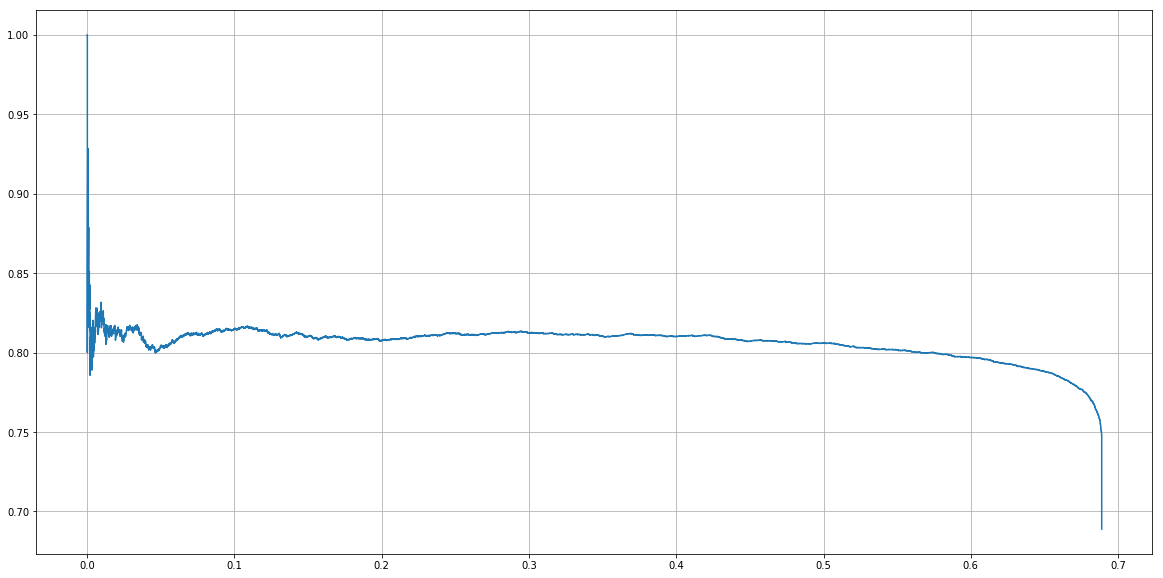

In [85]:
figure(figsize=(20,10))
plot(rs, ps)
grid()

In [49]:
for i in range(10): print(i, end='\r')

In [55]:
rs.max()

0.6889004689942678

In [56]:
rs.min()

3.722176728951091e-05

In [57]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [59]:
func = interp1d(rs, ps)

In [65]:
mAP = quad(lambda x: func(x), rs[0], rs[-1])

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  """Entry point for launching an IPython kernel.


In [66]:
mAP

(0.5553826637303485, 5.407731600481913e-05)

In [67]:
ps_9, rs_9 = evaluate_fd(gt_path, sol_path, 0.9)

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [68]:
func = interp1d(rs_9, ps_9)
quad(lambda x: func(x), rs_9[0], rs_9[-1])

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


(4.525356868807096e-05, 1.2643668468998018e-07)

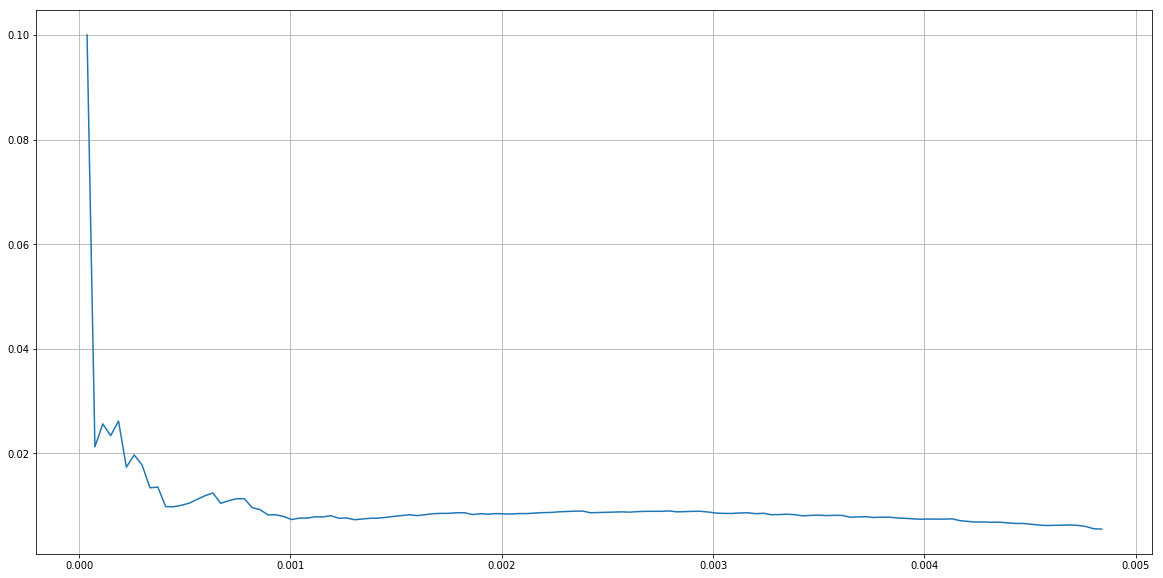

In [69]:
figure(figsize=(20,10))
plot(rs_9, ps_9)
grid()

In [70]:
rs_9.max()

0.004838829747636417

In [71]:
ps_7, rs_7 = evaluate_fd(gt_path, sol_path, 0.7)

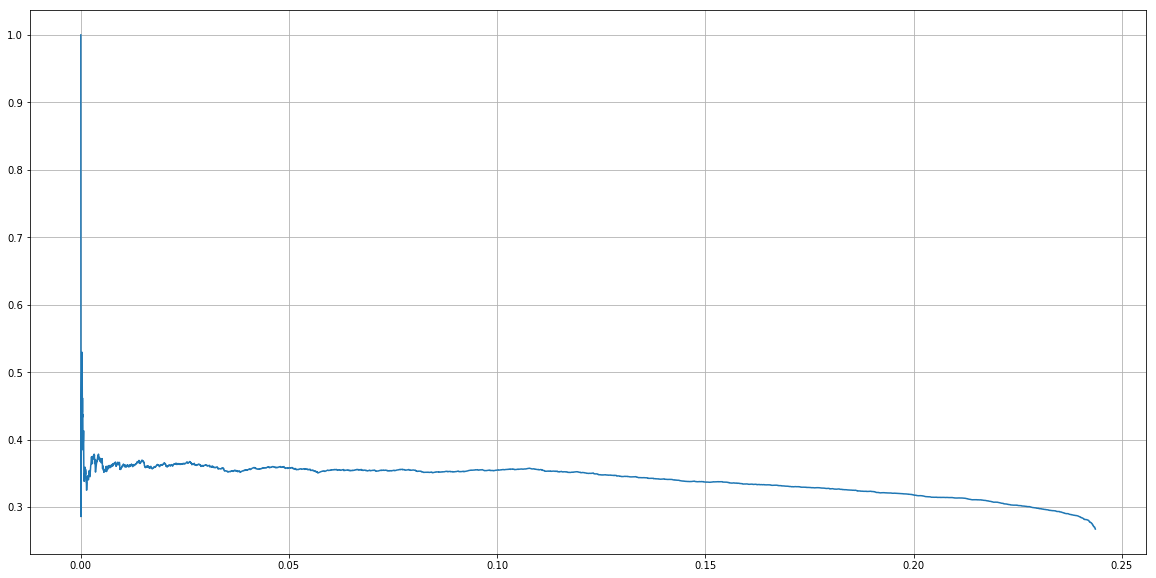

In [72]:
figure(figsize=(20,10))
plot(rs_7, ps_7)
grid()

In [73]:
func = interp1d(rs_7, ps_7)
quad(lambda x: func(x), rs_7[0], rs_7[-1])

D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


(0.08274781890970458, 7.646777534869864e-06)

In [26]:
import h5py

In [53]:
f = h5py.File('sample.h5','w')

In [54]:
top = f.create_group('top')

In [55]:
top['0'] = np.random.rand(10)
top['1'] = np.random.rand(10)

In [56]:
top['0'].shape

(10,)

In [57]:
top['0'].attrs['id'] = 100

In [58]:
top['0'].attrs['id']

100

In [59]:
f.close()

In [60]:
ls

 D 드라이브의 볼륨: DATA
 볼륨 일련 번호: 40C4-7DAF

 D:\topcoder\face_recog\src\space 디렉터리

2019-05-29  오후 09:12    <DIR>          .
2019-05-29  오후 09:12    <DIR>          ..
2019-04-25  오후 05:13               158 .gitignore
2019-05-27  오후 11:10                92 __init__.py
2019-05-22  오전 02:45    <DIR>          __pycache__
2019-04-21  오후 10:08           744,004 db.csv
2019-05-22  오전 02:27           340,791 db_facial_id.pobj
2019-04-29  오후 11:01           604,649 es.csv
2019-05-29  오후 04:52             5,806 evaluate.py
2019-05-29  오후 07:14            40,904 face_detection.py
2019-05-22  오전 11:35       488,322,408 face_detector.h5
2019-05-29  오후 07:29            47,025 face_identification.py
2019-05-22  오전 02:26       620,573,520 face_identifier.h5
2019-05-17  오후 01:03       620,573,520 face_reidentifier.hd5
2019-05-29  오후 07:24             1,195 face_vijnana_yolov3.json
2019-05-03  오전 07:31         8,701,531 img_triplet_pairs.pickle
2019-05-29  오후 09:23             4,752 sample.h5
2019-04-25  오후

In [61]:
f = h5py.File('sample.h5','r')

In [62]:
f.keys()

KeysView(<HDF5 file "sample.h5" (mode r)>)

In [63]:
f.name

'/'

In [64]:
for name in f: print(name)

top


In [68]:
f['top']['0'].value

array([0.34670551, 0.57372988, 0.53244002, 0.37849571, 0.69450392,
       0.19979125, 0.62840678, 0.59146162, 0.85161414, 0.22788428])

In [98]:
sample = np.random.rand(10)
sample = sample <= 0.5

In [99]:
sample

array([ True, False,  True,  True,  True,  True, False, False,  True,
        True])

In [100]:
sample2 = sample.astype(np.int64)

In [101]:
sample2

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 1], dtype=int64)

In [102]:
sample2.sum()

7

In [2]:
cd D:\topcoder\\face_recog\src\space

D:\topcoder\face_recog\src\space


In [3]:
import evaluate

Using TensorFlow backend.


In [6]:
import importlib
importlib.reload(evaluate)

<module 'evaluate' from 'D:\\topcoder\\face_recog\\src\\space\\evaluate.py'>

In [9]:
import pandas as pd
sample = pd.DataFrame({'a': range(10), 'b': range(10)})

In [14]:
sample.iloc[0, :]

a    0
b    0
Name: 0, dtype: int64

In [16]:
ls

 D 드라이브의 볼륨: DATA
 볼륨 일련 번호: 40C4-7DAF

 D:\topcoder\face_recog\src\space 디렉터리

2019-05-31  오전 09:37    <DIR>          .
2019-05-31  오전 09:37    <DIR>          ..
2019-04-25  오후 05:13               158 .gitignore
2019-05-27  오후 11:10                92 __init__.py
2019-05-30  오후 03:38    <DIR>          __pycache__
2019-05-22  오전 02:27           340,791 db_facial_id.pobj
2019-04-29  오후 11:01           604,649 es.csv
2019-05-31  오전 09:39            11,831 evaluate.py
2019-05-30  오후 03:54            40,888 face_detection.py
2019-05-30  오전 10:27       488,322,408 face_detector.h5
2019-05-22  오전 11:35       488,322,408 face_detector.h5.v1
2019-05-30  오전 03:48            47,141 face_identification.py
2019-05-22  오전 02:26       620,573,520 face_identifier.h5
2019-05-17  오후 01:03       620,573,520 face_reidentifier.hd5
2019-05-30  오후 05:30             1,185 face_vijnana_yolov3.json
2019-05-03  오전 07:31         8,701,531 img_triplet_pairs.pickle
2019-05-31  오전 09:37           190,216 p_r_curve.h

In [19]:
import h5py
f = h5py.File('p_r_curve.h5', 'r')

In [20]:
ps = f['ps'].value

In [21]:
rs = f['rs'].value

In [23]:
f['mAP'].value

0.6856955426575898

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\Users\gutom\Anaconda3\envs\tf36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


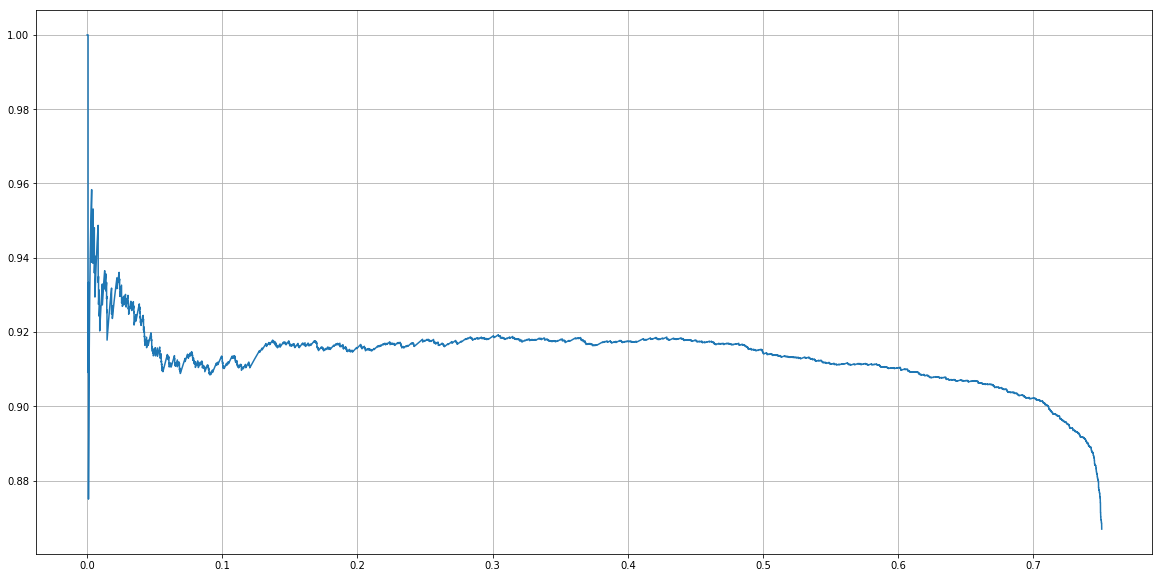

In [26]:
figure(figsize=(20, 10))
plot(rs, ps)
grid()

In [50]:
input1 = Input(shape=(10,10,3))
x = Lambda(lambda x: K.sigmoid(x[..., 0:2]))(input1)
#x1 = Lambda(lambda x: K.expand_dims(K.sigmoid(x[..., 0:3])))(input1)
#x2 = Lambda(lambda x: K.expand_dims(K.log(x[..., 1])))(input1)
#x3 = Lambda(lambda x: K.expand_dims(K.exp(x[..., 2])))(input1)
#x = Concatenate()([x1, x2, x3])
model = Model(input1, x)

In [51]:
res = model.predict(np.ones(shape=(1,10,10,3)))

In [52]:
res.shape

(1, 10, 10, 2)

In [53]:
res

array([[[[0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586]],

        [[0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586]],

        [[0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586],
         [0.7310586, 0.7310586]],

    